In [1]:
# libraries
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import choices
from itertools import chain
# Levenshtein Distance in Python
import textdistance
import re
import unicodedata
import time
from rank_bm25 import BM25Okapi, BM25L
# https://github.com/seatgeek/thefuzz
from thefuzz import fuzz, process

# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)

# Pandas config
pd.options.mode.chained_assignment = None  # default='warn'

### Load grouftruth dataset

In [2]:
matches_training_df = pd.read_parquet('data/matches_training.parquet')

In [3]:
# set random seed
np.random.seed(seed=42)

### Offers training

In [4]:
#offers_training_df = pd.read_parquet('offers_training.parquet')
#offers_test_df = pd.read_parquet('offers_test.parquet')

### Run utils script
Loads functions for exploration and metrics

In [5]:
%run ./utils/utils.py

## Brand analysis

### Brand text processing
- Lower case text
- Accented vowels removal `è, é, ... -> e`
- Stop words removal (German)

In [6]:
stop_word_list = []

with open('processing/text_processing/german_stopwords.txt', "r") as f:
    stop_word_list = f.read().split()

In [7]:
class TextTransformer:
    def processed_text(self, text):
        if text is None:
            return ''
        #lower
        processed = text.lower()
        #remove accents
        processed = self.simplify(processed)
        #remove special characters
        processed = ''.join(c if c.isalnum() or c == ' ' else ' ' for c in processed)
        #remove unnecessary double spaces
        processed = re.sub(' +', ' ', processed)
        #strip
        processed = processed.strip()
        #remove stopwords
        processed_list = [word for word in processed.split() if word not in stop_word_list]
        return ' '.join(processed_list)
    
    def simplify(self, text):
        try:
            text = unicode(text, 'utf-8')
        except NameError:
            pass
        text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
        return str(text)

### Read files for german colors transformation

In [8]:
with open('processing/color_processing/kfix_de.txt') as f:
    color_kfix_list = f.read().splitlines() 

with open('processing/color_processing/primary_colors_de.txt') as f:
    primary_colors = f.read().splitlines() 
color_matches = {}
with open('processing/color_processing/color_matches_de.txt') as f:
    for line in f:
        (key, val) = line.split(':')
        val = val.strip()
        color_matches[key] = val

### Read files for german titles transformation

In [9]:
with open('processing/title_processing/kfix_de.txt') as f:
    clothes_kfix_list = f.read().splitlines() 

with open('processing/title_processing/primary_clothes_de.txt') as f:
    primary_clothes = f.read().splitlines() 
clothes_matches = {}
with open('processing/title_processing/clothes_matches_de.txt') as f:
    for line in f:
        (key, val) = line.split(':')
        val = val.strip()
        clothes_matches[key] = val

In [10]:
class SpecificTrasformer(TextTransformer):
    def __init__(self,
                 kfix_list, 
                 matches, 
                 primary):
        self.kfix_list = kfix_list
        self.matches = matches
        self.primary = primary
    def separe_word(self, text, word):
        i = text.find(word)
        text = text[:i] + ' ' + text[i:] if i != -1 else text
        return text[:i+len(word)+1] + ' ' + text[i+len(word)+1:] if i != -1 else text
    def separe_words(self, text):
        for color in self.primary:
            text = self.separe_word(text, color)
        return text
    def replace_words(self, text):
        for k, v in self.matches.items():
            text = text.replace(k, v)
        return text
    def remove_kfix(self, text):
        for suffix in self.kfix_list:
            text = text.replace(suffix, '')
        return text
    
    def processed_text(self, text):
        splitted = super().processed_text(text).split()
        #1 transform matches
        splitted = [self.replace_words(text) for text in splitted]
        #2 suffix removal
        splitted = [self.remove_kfix(text) for text in splitted]
        #separate primary colors
        splitted = [self.separe_words(term) for term in splitted]
        return re.sub(' +', ' ', ' '.join(splitted).strip())

### Instance of text transformers

In [11]:
tt = TextTransformer()
ct = SpecificTrasformer(color_kfix_list, color_matches, primary_colors)
titlet = SpecificTrasformer(clothes_kfix_list, clothes_matches, primary_clothes)

### Class for brand management

In [12]:
brands_training = offers_training_df['brand'].unique()
brands_test = offers_test_df['brand'].unique()

In [13]:
def similarity(str_1, str_2):
    return textdistance.levenshtein.normalized_similarity(str_1, str_2)

In [14]:
class Brand:
    def __init__(self, name, parent=None, child=list()):
        self.name = name
        self.parent = parent
        self.child = child

In [15]:
class BrandCollection:
    def __init__(self, brand_list):
        self.brands = {}
        self.brand_family = {}
        self.manual_matches = {}
        #brand_list = [TextTransformer(x).processed_text() for x in brand_list]
        brand_list.sort()
        for el in brand_list:
            self.process_brand(Brand(el))
    
    def process_brand(self, brand):
        if brand.name not in self.brands:
            parent_likelyhood = 0
            likely_parent = None
            for k in self.brands.keys():
                comp = self.brands[k]
                l_comp = self.listify(comp, brand)
                l_brand = self.listify(brand, comp)
                calc_likelyhood = self.parent_likelyhood(l_comp, l_brand)
                if calc_likelyhood > parent_likelyhood:
                    parent_likelyhood = calc_likelyhood
                    brand.parent = comp
                    likely_parent = self.brands[comp.name]
            self.brands[brand.name] = brand
            self.brand_family[brand] = []
            if likely_parent is not None:
                self.brand_family[likely_parent].append(brand)
    
    def listify(self, brand, to_compare):
        l_brand = brand.name.split()
        l_comp = to_compare.name.split()
        max_len = len(l_brand) if len(l_brand) > len(l_comp) else len(l_comp)
        if len(l_brand) == max_len:
            return l_brand
        for i in range(max_len - len(l_brand)):
            l_brand += ['']
        return l_brand
    
    def parent_likelyhood(self, l_comp, l_brand):
        likelyhood = 0
        #check longest matching n-gram, does not check for combinations
        for i in range(len(l_comp)):
            if l_comp[i] == l_brand[i]:
                likelyhood += 1
            else:
                return likelyhood
        return likelyhood
    
    def similarity(self, str_1, str_2):
        return textdistance.levenshtein.normalized_similarity(str_1, str_2)
    
    def get_match(self, brand_query):
        brand_to_search = Brand(tt.processed_text(brand_query))
        if brand_to_search.name in self.brands:
            selected_brand = self.brands[brand_to_search.name]
            while selected_brand.parent is not None:
                selected_brand = selected_brand.parent
            brands = self.get_brand_family(selected_brand.name)
            return brands, 1
        else:
            relevance = 0
            most_relevant = '-'
            for key in self.brands.keys():
                sim = self.similarity(brand_to_search.name, self.brands[key].name)
                if sim > relevance:
                    relevance = sim
                    most_relevant = self.brands[key].name
            brands = self.get_brand_family(most_relevant)
            return brands, relevance
            
    def get_brand_family(self, brand_name):
        fam_list = [brand_name]
        family = []
        while len(fam_list) != 0:
            current = fam_list[0]
            fam_list += [b.name for b in self.brand_family[self.brands[current]]]
            fam_list.remove(current)
            if current not in family:
                family += [current]
        if brand_name in self.manual_matches.keys():
            family += self.manual_matches[brand_name]
        return list(set(family))
    
    def add_manual_match(self, brand_a, brand_b):
        if brand_a not in self.manual_matches.keys():
            self.manual_matches[brand_a] = [brand_b]
        else:
            if brand_b not in self.manual_matches[brand_a]:
                self.manual_matches[brand_a] += [brand_b]
                
        if brand_b not in self.manual_matches.keys():
            self.manual_matches[brand_b] = [brand_a]
        else:
            if brand_a not in self.manual_matches[brand_b]:
                self.manual_matches[brand_b] += [brand_a]

### Product name matching VSM - BM25

In [16]:
class TextRelevance:
    def __init__(self, text, relevance):
        self.text = text
        self.relevance = relevance
    def __repr__(self):
        return self.text + ' ' + str(self.relevance)
    def __eq__(self, other):
        return self.text == other.text
    def __hash__(self):
        return hash(self.text)

In [17]:
class BM25Z(BM25L):
    def __init__(self, corpus):
        super().__init__(self.process_list(corpus))
        self.corpus = self.process_list(corpus)
    def process_list(self, titles_list):
        return [text.split() for text in titles_list if text is not None]
    def processed_text(self, text):
        return tt.processed_text(text)
    def get_corpus_str(self):
        return [' '.join(el) for el in self.corpus]
    def get_corpus_scores(self, query):
        query = self.processed_text(query).split()
        return [TextRelevance(x,y) for x, y in zip(self.get_corpus_str(), self.get_scores(query))]
    def get_relevant_results(self, query, threshold=0):
        res = [el for el in self.get_corpus_scores(query) if el.relevance > threshold]
        res = sorted(res, key=lambda x: x.relevance, reverse=True)
        return res

### Clean dataset

In [18]:
zalando_prod_training = offers_training_df.loc[offers_training_df['shop'] == 'zalando']
zalando_prod_training = zalando_prod_training\
                    .loc[zalando_prod_training['offer_id'].isin(matches_training_df['zalando'])]
zalando_prod_training['brand'] = zalando_prod_training['brand']\
                    .apply(lambda x: tt.processed_text(x))
zalando_prod_training['title'] = zalando_prod_training['title']\
                    .apply(lambda x: titlet.processed_text(x))
zalando_prod_training['color'] = zalando_prod_training['color']\
                    .apply(lambda x: ct.processed_text(x))
#zalando_prod_training['description'] = zalando_prod_training['description']\
#                    .apply(lambda x: TextTransformer(x).processed_text())

aboutyou_prod_training = offers_training_df.loc[offers_training_df['shop'] == 'aboutyou']
aboutyou_prod_training['brand'] = aboutyou_prod_training['brand']\
                    .apply(lambda x: tt.processed_text(x))
aboutyou_prod_training['title'] = aboutyou_prod_training['title']\
                    .apply(lambda x: titlet.processed_text(x))
aboutyou_prod_training['color'] = aboutyou_prod_training['color']\
                    .apply(lambda x: ct.processed_text(x))
#aboutyou_prod_training['description'] = aboutyou_prod_training['description']\
#                    .apply(lambda x: TextTransformer(x).processed_text())

fields = ['shop','offer_id', 'brand', 'title', 'description']

### Instance of matchers

In [19]:
brand_collection = BrandCollection(list(zalando_prod_training['brand']) + list(aboutyou_prod_training['brand']))

bm25matcher_title = BM25Z(list(aboutyou_prod_training['title']))

bm25matcher_color = BM25Z(list(aboutyou_prod_training['color']))

#bm25matcher_descr = BM25Z(list(aboutyou_prod_training['description']))

In [20]:
#bm25matcher_title.get_relevant_results('kleid')[-10:]

### Brand likelyhood

Some products are listed under different brand names, identify them using groundtruth

In [21]:
def brand_manual_matching():
    for i in range(len(matches_training_df)):
        groundtruth_match = matches_training_df.loc[i]
        z_id, a_id = groundtruth_match['zalando'], groundtruth_match['aboutyou']
        zalando_brand = zalando_prod_training\
                        .loc[zalando_prod_training['offer_id'] == z_id]['brand'].values[0]
        aboutyou_brand = aboutyou_prod_training\
                        .loc[aboutyou_prod_training['offer_id'] == a_id]['brand'].values[0]
        
        brand_to_match = brand_collection.get_match(zalando_brand)[0]        
        if aboutyou_brand not in brand_to_match:
            for z_brand in brand_to_match:
                brand_collection.add_manual_match(z_brand, aboutyou_brand)

### Training brands using groundtruth matches

In [22]:
brand_manual_matching() #UNABLED enable it again

In [23]:
def brand_likely_matches(n):
    """
    n is the row number of the product in aboutyou dataset
    try to compare 1 zalando product with aboutyou products
    """
    try:
        prod_to_match = zalando_prod_training.loc[n]
        id_prod = prod_to_match['offer_id']
    except:
        return {'zalando_id' : None, 'aboutyou_ids' : []}
    #get subset of possible brands to investigate
    match_brands, rel = brand_collection.get_match(prod_to_match['brand'])
    aboutyou_prod_brand_match = aboutyou_prod_training\
                                .loc[aboutyou_prod_training['brand']\
                                .isin(match_brands)]
        
    if len(aboutyou_prod_brand_match['title']) == 0:
        return {'zalando_id' : id_prod, 'aboutyou_ids' : []}
    
    return {'zalando_id' : id_prod, 'aboutyou_ids' : list(aboutyou_prod_brand_match['offer_id'])}

### Title likelyhood
Title matching with BM25 categorize correctly up to 58% of offers, with good accuracy (number of results per query): 0.6214

In [24]:
def title_likely_matches(n):
    try:
        prod_to_match = zalando_prod_training.loc[n]
        id_prod = prod_to_match['offer_id']
    except:
        return {'zalando_id' : None, 'aboutyou_ids' : []}
    
    match_titles_relevance = list(dict.fromkeys(bm25matcher_title.get_relevant_results(prod_to_match['title'])))
    match_titles = [x.text for x in match_titles_relevance]

    aboutyou_prod_title_match = aboutyou_prod_training\
                                .loc[aboutyou_prod_training['title']\
                                .isin(match_titles)]
    
    if len(aboutyou_prod_title_match['title']) == 0:
        return {'zalando_id' : id_prod, 'aboutyou_ids' : []}
    
    return {'zalando_id' : id_prod, 'aboutyou_ids' : list(aboutyou_prod_title_match['offer_id'])}

In [25]:
def print_color_matches():
    for i in range(0, len(matches_training_df)):
        groundtruth_match = matches_training_df.loc[i]
        z_id, a_id = groundtruth_match['zalando'], groundtruth_match['aboutyou']
        z_color = zalando_prod_training\
                        .loc[zalando_prod_training['offer_id'] == z_id]['color'].values[0]
        a_color = aboutyou_prod_training\
                        .loc[aboutyou_prod_training['offer_id'] == a_id]['color'].values[0]
        print(z_color, '-', a_color)
#print_color_matches()

In [26]:
def color_likely_matches(n):
    try:
        prod_to_match = zalando_prod_training.loc[n]
        id_prod = prod_to_match['offer_id']
    except:
        return {'zalando_id' : None, 'aboutyou_ids' : []}
    
    match_titles_relevance = list(dict.fromkeys(bm25matcher_color.get_relevant_results(prod_to_match['color'])))
    match_titles = [x.text for x in match_titles_relevance]

    aboutyou_prod_color_match = aboutyou_prod_training\
                                .loc[aboutyou_prod_training['color']\
                                .isin(match_titles)]
    
    if len(aboutyou_prod_color_match['color']) == 0:
        return {'zalando_id' : id_prod, 'aboutyou_ids' : []}
    
    return {'zalando_id' : id_prod, 'aboutyou_ids' : list(aboutyou_prod_color_match['offer_id'])}

In [27]:
#bm25matcher_color.idf
#aboutyou_prod_training[['color']].head(30)

In [28]:
def descr_likely_matches(n):
    try:
        prod_to_match = zalando_prod_training.loc[n]
        id_prod = prod_to_match['offer_id']
    except:
        return {'zalando_id' : None, 'aboutyou_ids' : []}
    
    match_titles_relevance = list(dict.fromkeys(bm25matcher_descr.get_relevant_results(prod_to_match['description'])))
    match_titles = [x.text for x in match_titles_relevance]

    aboutyou_prod_descr_match = aboutyou_prod_training\
                                .loc[aboutyou_prod_training['description']\
                                .isin(match_titles)]
    
    if len(aboutyou_prod_descr_match['color']) == 0:
        return {'zalando_id' : id_prod, 'aboutyou_ids' : []}
    
    return {'zalando_id' : id_prod, 'aboutyou_ids' : list(aboutyou_prod_descr_match['offer_id'])}

### Price analysis
Using groundtruth to understand price differences

In [29]:
from scipy import stats

In [30]:
def get_price_difference(limit = 500):
    price_diff = []
    for i in range(len(matches_training_df)):
        z_id = matches_training_df.loc[i]['zalando']
        a_id = matches_training_df.loc[i]['aboutyou']
        z_price = offers_training_df.loc[offers_training_df['offer_id'] == z_id]['price'].values[0]
        a_price = offers_training_df.loc[offers_training_df['offer_id'] == a_id]['price'].values[0]
        price_diff += [np.abs(round((z_price - a_price)/z_price, 2))] if not np.isnan(z_price - a_price) else []
        if i > limit-1:
            break
    return price_diff

### Train the model for price difference

In [31]:
price_diff = get_price_difference(10000)

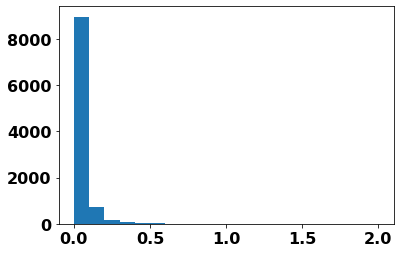

In [32]:
a = np.hstack(price_diff)
plt.hist(a, bins=20)
plt.show()

In [33]:
def price_likely_match(abs_diff):
    price_diff_list = price_diff[:]
    price_diff_list.sort()
    i = 0
    while price_diff_list[i] < abs_diff:
        if i == len(price_diff_list) - 1:
            return 0
        i += 1
    return 1 - i/len(price_diff_list)

price_likely_match(10)

0

In [34]:
def get_n_matches(n, fn_likely_matches):
    likely_matches = []
    i = 0
    while len(likely_matches) != n:
        m = fn_likely_matches(i)
        if m['zalando_id'] != None:
            likely_matches += [fn_likely_matches(i)]
        i += 1
    return likely_matches

#brand_matches = get_n_matches(10, brand_likely_matches)
#title_matches = get_n_matches(len(matches_training_df), title_likely_matches)
#color_matches = get_n_matches(len(matches_training_df), color_likely_matches)
#descr_matches = get_n_matches(100, descr_likely_matches)

In [35]:
def is_present(predicted_match):
    zalando_id = predicted_match['zalando_id']
    return len(matches_training_df.loc[matches_training_df['zalando'] == zalando_id]['aboutyou'])

def print_attributes_values(z_id, a_id, attribute):
    z_a = zalando_prod_training\
                        .loc[zalando_prod_training['offer_id'] == z_id][attribute].values[0]
    a_a = aboutyou_prod_training\
                        .loc[aboutyou_prod_training['offer_id'] == a_id][attribute].values[0]
    print(z_a, '-', a_a)

def is_match(predicted_match):
    zalando_id = predicted_match['zalando_id']
    df_not_matched = pd.DataFrame(columns=['zalando', 'aboutyou'])
    if is_present(predicted_match):
        match = matches_training_df\
        .loc[matches_training_df['zalando'] == zalando_id]['aboutyou'].values[0]
        
        aboutyou_match_truth_id = matches_training_df\
                        .loc[matches_training_df['zalando'] == zalando_id]['aboutyou'].values[0]
     
        isin = match in predicted_match['aboutyou_ids']
        row = {}
        if not isin:
            row = {'zalando':zalando_id, 'aboutyou': match}
            print_attributes_values(zalando_id, aboutyou_match_truth_id, 'offer_id')
            pass
        return isin, row
    return None

def print_weight(str_feature, matches):
    print(str_feature + ' matching:', 
      calc_match_rate(matches),
      'over:', len(matches), 'matches,',
      'accuracy:', calc_match_accuracy(matches)
     )
    
def calc_match_rate(matches):
    l = []
    df_not_matched = pd.DataFrame(columns=['zalando', 'aboutyou'])
    for i in range(len(matches)):
        is_m, row = is_match(matches[i])
        l += [is_m]
        if not is_m:
            df_not_matched = df_not_matched.append(row, ignore_index=True)
    return l.count(True) / len(matches), df_not_matched

def calc_match_accuracy(matches, scale=1000):
    return scale / np.mean([len(matches[i]['aboutyou_ids']) for i in range(len(matches))])



#print_weight('brand', brand_matches)
#print_weight('title', title_matches)
#rate, title_not_matched = calc_match_rate(title_matches)
#print_weight('color', color_matches)
#rate, color_not_matched = calc_match_rate(color_matches)
#print_weight('descr', descr_matches)
#title_not_matched

In [36]:
#title_not_matched.to_parquet('title_not_matched.parquet')
#len(title_not_matched)/len(matches_training_df)
#color_not_matched.to_parquet('color_not_matched.parquet')
#len(color_not_matched)/len(matches_training_df)

In [37]:
def get_rank_score(el_list, el):
    try:
        rank = el_list.index(el)
    except:
        return 0
    return (len(el_list) - rank) / len(el_list)

In [38]:
def calculate_match_score(zalando_offer_id, aboutyou_offer_id, subset_offers=[]):

    zalando_offer = zalando_prod_training.loc[zalando_prod_training['offer_id'] == zalando_offer_id]
    aboutyou_offer = aboutyou_prod_training.loc[aboutyou_prod_training['offer_id'] == aboutyou_offer_id]
    zalando_index = zalando_offer.index.values[0]
    
    brand_weight = 1
    brand_matches = subset_offers#brand_likely_matches(zalando_index)
    #brand_in = aboutyou_offer_id in brand_matches['aboutyou_ids']
    brand_in = aboutyou_offer_id in brand_matches
    brand_score = int(brand_in)
    
    title_weight = 1
    title_matches = subset_offers#title_likely_matches(zalando_index)
    #title_score = get_rank_score(title_matches['aboutyou_ids'], aboutyou_offer_id)
    title_score = get_rank_score(title_matches, aboutyou_offer_id)
    
    color_weight = 1
    color_matches = subset_offers#color_likely_matches(zalando_index)
    #color_score = get_rank_score(color_matches['aboutyou_ids'], aboutyou_offer_id)
    color_score = get_rank_score(color_matches, aboutyou_offer_id)
    
    price_weight = 1
    z_p, a_p = zalando_offer['price'].values[0], aboutyou_offer['price'].values[0]
    price_diff = np.abs((z_p - a_p) / z_p)
    price_score = price_likely_match(price_diff)
    
    score = brand_score * brand_weight +\
            title_score * title_weight +\
            color_score * color_weight +\
            price_score * price_weight
    return score

#calculate_match_score('b33f55d6-0149-4063-8b63-3eeae63562a2', 'ad5ceb87-0254-4171-b650-1d4d09f48efc')

In [39]:
#To limit the results and improve time efficency
def get_matches(z_id):
    zalando_offer = zalando_prod_training.loc[zalando_prod_training['offer_id'] == z_id]
    brand_name = zalando_offer['brand'].values[0]
    match_brands = brand_collection.get_match(brand_name)[0]
    
    #Brand Match
    aboutyou_prod_brand_match = set(aboutyou_prod_training\
                                .loc[aboutyou_prod_training['brand']\
                                .isin(match_brands)]['offer_id'].values)
    
    #Title Match
    match_titles_relevance = list(dict.fromkeys(bm25matcher_title.get_relevant_results(zalando_offer['title'].values[0])))
    match_titles = [x.text for x in match_titles_relevance]
    aboutyou_prod_title_match = set(aboutyou_prod_training\
                                .loc[aboutyou_prod_training['title']\
                                .isin(match_titles)]['offer_id'].values)
    
    #Color Match
    match_color_relevance = list(dict.fromkeys(bm25matcher_color.get_relevant_results(zalando_offer['color'].values[0])))
    match_color = [x.text for x in match_color_relevance]
    aboutyou_prod_color_match = set(aboutyou_prod_training\
                                .loc[aboutyou_prod_training['color']\
                                .isin(match_color)]['offer_id'].values)
    
    match_intersect_set = aboutyou_prod_brand_match\
                            .intersection(aboutyou_prod_color_match)\
                            .intersection(aboutyou_prod_title_match)
    
    return match_intersect_set

In [40]:
def get_best_match(z_id, a_ids_list, limit=1):
    df_score = pd.DataFrame(columns=['zalando', 'aboutyou', 'score'])
    for id in a_ids_list:
        row = {'zalando':z_id, 'aboutyou': id, 'score': calculate_match_score(z_id, id, a_ids_list)}
        df_score = df_score.append(row, ignore_index=True)
    return df_score.sort_values(by=['score'], ascending=False).head(limit)


#m = get_best_match('b33f55d6-0149-4063-8b63-3eeae63562a2', matches_training_df['aboutyou'].values[0:1000])

In [41]:
def create_matches_df(z_ids_list, result_per_item=10):
    df_predicted_matches = pd.DataFrame(columns=['zalando', 'aboutyou', 'score'])
    df_best_n_matches = pd.DataFrame(columns=['zalando', 'aboutyou', 'score'])
    for z_id in z_ids_list:
        subset_comp = get_matches(z_id)
        prediction = get_best_match(z_id, subset_comp, result_per_item)
        df_predicted_matches = df_predicted_matches.append(prediction.head(1), ignore_index=True)
        df_best_n_matches = df_best_n_matches.append(prediction, ignore_index=True)
        #print(len(prediction))
        #print(len(df_best_n_matches))
    return df_predicted_matches, df_best_n_matches

In [ ]:
start = time.time()
pred, best_n_matches = create_matches_df(list(matches_training_df['zalando'].values))
get_matches(list(matches_training_df['zalando'].values)[0])
end = time.time()
print('Computation time:', round(end-start, 4), 'sec')

In [ ]:
get_metrics(
            matches_training_df.loc[:len(pred)+1], 
            pred, 
            best_n_matches, 
            aboutyou_prod_training, 
            matches_training_df
           )

In [ ]:
explore_match(pred.loc[1], matches_training_df)